# Adding a dense layer to VGG

The last layer of Vgg16 outputs a vector of 1000 categories, because that is the number of categories the competition asked for. Of these categories, some of them certainly correspond to cats and dogs, but at a much more granular level (specific breeds).

We will simply add a Dense layer on top of the imagenet layer, and train the model to map the imagenet classifications of input images of cats and dogs to cat and dog labels.

Note that this is not what we have been doing in the very first lecture!

Note also that this approach is closely related to Exercise 2 of last lecture.

Have a look at [CS231n: Linear Classification](http://cs231n.github.io/linear-classify/) for more precisions and especially to [CS231n: Softmax classifier](http://cs231n.github.io/linear-classify/#softmax) if you had trouble with Exercise 2 of last lecture.

## 1. Preparations

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import bcolz
import time
%matplotlib inline

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

We will first precompute the outputs of Vgg16 model on our dataset and store these values.

In [22]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

dtype = torch.FloatTensor
if use_gpu:
    dtype = torch.cuda.FloatTensor

Using gpu: False 


In [4]:
#data_dir = '/home/lelarge/courses/data/dogsandcats/sample'
#data_dir = '/home/ubuntu/data/dogscats/sample'
data_dir = '/home/ubuntu/data/dogscats'


Initialize paths for dataset items

In [5]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'valid']}

If you are running on CPU, you will probably need to lower the size of the batches.

In [23]:
# batch_size = 64
batch_size = 4 

Initialize data loader that will fetch images from disk using num_workers parallel threads.

In [7]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'valid']}

In [ ]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

Instantiate VGG16 model pretrained on ImageNet from the ```torchvision``` model Zoo.

In [9]:
model_vgg = models.vgg16(pretrained=True)

In [10]:
if use_gpu:
    model_vgg = model_vgg.cuda()

By default all the modules are initialized to train mode (```self.training = True```). Also be aware that some layers have different behavior during train/and evaluation (like _BatchNorm_, _Dropout_) so setting it matters.

Also as a rule of thumb for programming in general, try to explicitly state your intent and set ```model.train()``` and ```model.eval()``` when necessary.

In [24]:
model_vgg.eval()

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

## 2. Feature extraction

Function for extracting and storing CNN features, i.e. the ouput of VGG16 model in this case.

In [12]:
def prefeat(dataset):
    features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg(inputs)
        features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    features = np.concatenate([[feat] for feat in features])
    return (features,labels_list)

In [13]:
%%time
feat_train,labels_train = prefeat(dset_loaders['train'])

CPU times: user 3min 43s, sys: 22.1 s, total: 4min 5s
Wall time: 1min 3s


In [ ]:
feat_train.shape

Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz (already loaded above...).

In [15]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [16]:
save_array(os.path.join(data_dir,'vgg16','feat_train.bc'),feat_train)
save_array(os.path.join(data_dir,'vgg16','lbs_train.bc',labels_train)

In [17]:
%%time
feat_val,lbs_val = prefeat(dset_loaders['valid'])

CPU times: user 54.1 s, sys: 5.58 s, total: 59.7 s
Wall time: 15.4 s


In [19]:
feat_val.shape

(2000, 1000)

In [19]:
save_array(os.path.join(data_dir,'vgg16','feat_val.bc'),feat_val)
save_array(os.path.join(data_dir,'vgg16','lbs_val.bc'),lbs_val)

In [20]:
feat_train = load_array(os.path.join(data_dir,'vgg16','feat_train.bc'))
lbs_train = load_array(os.path.join(data_dir,'vgg16','lbs_train.bc'))
feat_val = load_array(os.path.join(data_dir,'vgg16','feat_val.bc'))
lbs_val = load_array(os.path.join(data_dir,'vgg16','lbs_val.bc'))

## 3. Linear model for VGG16 features

We are now ready to define our linear model.

For more details about the [cross entropy cost function](http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function)

In [25]:
lm = torch.nn.Sequential(
    torch.nn.Linear(1000, 2),
    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
if use_gpu:
    lm = lm.cuda()

Since our features are currently stacked in a _numpy ndarray_, we will define a custom data loader to fetch random samples from it and group them in batches. 

In [26]:
def get_batches(feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    
    if shuffle:
        # generate a random index to simulate shuffling of the data
        index = np.random.permutation(len(feat))
        feat = feat[index]
        labels = labels[index]
    for idx in range(0,len(feat),batch_size):
        yield(feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### 3.1 Training

We define next a holistic training function (```train_model```) that will:
- run for a pre-defined number of epochs/iterations
- fetch training samples randomly during each epoch(all samples are used during an epoch)
- pass samples through network, compute error, gradients and updates network parameters
- keep and print training statistics: training loss, accuracy


In [41]:
def train_model(model,size,feat=None,labels=None,epochs=1,optimizer=None,batch_size=64,shuffle=True):
    model.train()
    loss_t = np.zeros(epochs)
    acc_t = np.zeros(epochs)
    for epoch in range(epochs):
        batches = get_batches(feat=feat,labels=labels,batch_size=batch_size,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            if use_gpu:
                inputs , classes = Variable(torch.from_numpy(inputs).cuda()),Variable(torch.from_numpy(classes).cuda())
            else:
                inputs , classes = Variable(torch.from_numpy(inputs)),Variable(torch.from_numpy(classes))
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = loss_fn(outputs,classes)           
            if optimizer is None:
                raise ValueError('Pass optimizer for train mode')
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        #print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        loss_t[epoch] = epoch_loss
        acc_t[epoch] = epoch_acc
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_t, acc_t

We set our hyperparameters:
- learning rate
- optimizer to be used for gradient descent, here SGD (Stochastic Gradient Descent)

In [42]:
learning_rate = 1e-4
optimizer_lm = torch.optim.SGD(lm.parameters(), lr=learning_rate)

We train our model for 100 epochs

In [43]:
%%time
loss1, acc1 = (train_model(model=lm,size=dset_sizes['train'],feat=feat_train,labels=lbs_train,
            epochs=100,optimizer=optimizer_lm,batch_size = 64,shuffle=True))

Loss: 0.3278 Acc: 0.9861
CPU times: user 34.5 s, sys: 3.68 s, total: 38.2 s
Wall time: 37.3 s


We plot the evolution of the training loss across epochs. 

Ideally is should have a steep descent in the first epochs, then decrease smoothly.

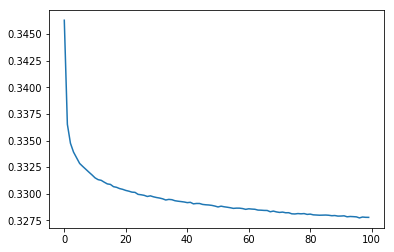

In [44]:
plt.plot(loss1)

We plot the evolution of the accuracy of our model on the training data. The behavior resembles globally to the one of the loss: big improvement at the beginning, then smaller improvements as training advances.


In [ ]:
plt.plot(acc1)

The __loss__ helps the network to learn and update the parameters according to the criterion that we give to the network.

The __accuracy__ on the other hand is a performance metric for the task for which we want to use the network for. In many cases the accuracy cannot be integrated as a loss/criterion function, so we need to identify or design loss functions that will guide the model towards the behavior we wish to have for our task.

Next we let the model train for 100 additional epochs

In [46]:
%%time
loss2, acc2 = (train_model(model=lm,size=dset_sizes['train'],feat=feat_train,labels=lbs_train,
            epochs=100,optimizer=optimizer_lm,shuffle=True)

Loss: 0.3266 Acc: 0.9878
CPU times: user 34.5 s, sys: 3.69 s, total: 38.2 s
Wall time: 37.3 s


Again we plot the loss and accuracy for the current training interval: _epochs[100:200]_.
What changes do you notice? 

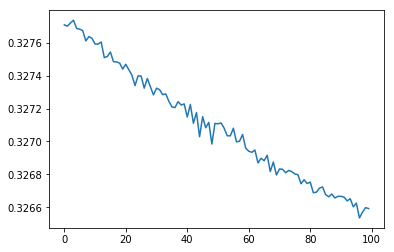

In [47]:
plt.plot(loss2)

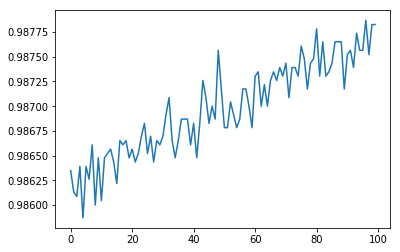

In [48]:
plt.plot(acc2)

We train the model train for 100 more epochs and plot the evolution of our training indicators. 
How are they evolving comparing to the previous runs?
 

In [49]:
%%time
loss3, acc3 = (train_model(model=lm,size=dset_sizes['train'],feat=feat_train,labels=lbs_train,
            epochs=100,optimizer=optimizer_lm,shuffle=True))

Loss: 0.3258 Acc: 0.9888
CPU times: user 34.8 s, sys: 4.44 s, total: 39.2 s
Wall time: 38.2 s


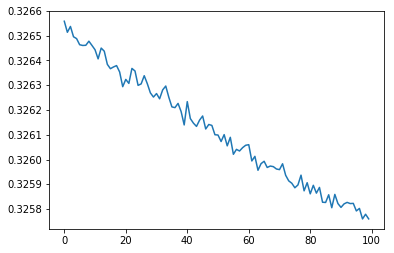

In [50]:
plt.plot(loss3)

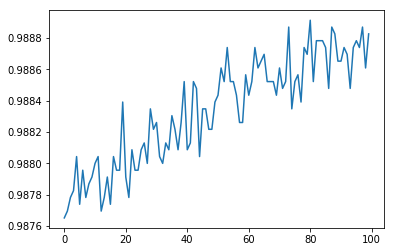

In [51]:
plt.plot(acc3)

### 3.2 Testing

We define next a holistic test function (```test_model```) that will:
- fetch test samples
- pass samples through network, compute error, accuracy and confusion matrix
- keep and print test statistics: test loss, accuracy


In [53]:
def test_model(model,size,feat=None,labels=None,batch_size=64):
    model.eval()
    batches = get_batches(feat=feat,labels=labels,batch_size=batch_size,shuffle=False)
    predictions = np.zeros(size)
    conf = np.zeros((size,2))
    running_loss = 0.0
    running_corrects = 0
    count = 0 
    for inputs,classes in batches:
        if use_gpu:
            inputs , classes = Variable(torch.from_numpy(inputs).cuda()),Variable(torch.from_numpy(classes).cuda())
        else:
            inputs , classes = Variable(torch.from_numpy(inputs)),Variable(torch.from_numpy(classes))
                
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        loss = loss_fn(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
        # statistics
        running_loss += loss.data[0]
        running_corrects += torch.sum(preds == classes.data)
        #print(count, 'Loss: {:.4f} Acc: {:.4f}'.format( loss.data[0]/ batch_size,
        #                                               torch.sum(preds == classes.data) / batch_size))
        if use_gpu:
            predictions[count*batch_size:(count+1)*batch_size] = preds.cpu().numpy()
            conf[count*batch_size:(count+1)*batch_size,:] = outputs.data.cpu().numpy()
        else:
            predictions[count*batch_size:(count+1)*batch_size] = preds.numpy()
            conf[count*batch_size:(count+1)*batch_size,:] = outputs.data.numpy()
        count +=1
        
    print('Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects / size))
    return predictions, conf, running_loss / size, running_corrects / size

We evaluate on the test data a snapshot of our model at _epoch #300_

In [54]:
%%time
preds, conf, loss_val, acc_val = (test_model(model=lm,size=dset_sizes['valid'],feat=feat_val,labels=lbs_val,batch_size=2000))

Loss: 0.3271 Acc: 0.9845
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.09 ms


In [55]:
loss_val

0.32710589599609374

## 4. Quantitative analysis

We concatenate the training losses across the 300 training epochs and plot them along with the loss on the test data using a snapshot of our model at epoch #300.

What do you notice? 

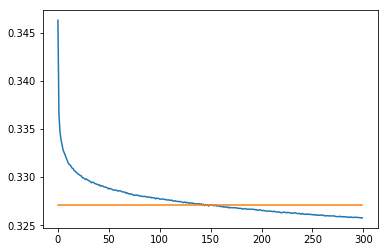

In [56]:
plt.plot(np.concatenate((loss1, loss2, loss3)))
plt.plot(loss_val*np.ones(300))

We illustrate a similar plot for the training loss values at _epochs[200:300]_

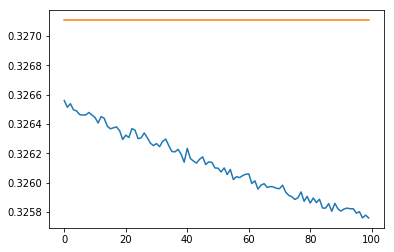

In [57]:
plt.plot(loss3)
plt.plot(loss_val*np.ones(100))

We now illustrate the aggregated training accuracies on epochs[0:300] along with the test accuracy for the model at epoch #300.

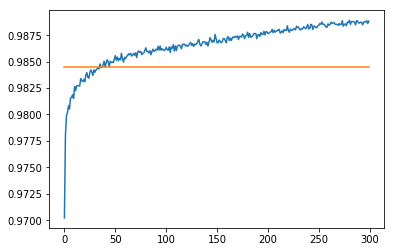

In [58]:
plt.plot(np.concatenate((acc1, acc2, acc3)))
plt.plot(acc_val*np.ones(300))

We train our model for 1000 more epochs.

In [59]:
%%time
loss4, acc4 = (train_model(model=lm,size=dset_sizes['train'],feat=feat_train,labels=lbs_train,
            epochs=1000,optimizer=optimizer_lm,shuffle=True))

Loss: 0.3232 Acc: 0.9914
CPU times: user 5min 47s, sys: 37.8 s, total: 6min 25s
Wall time: 6min 16s


We test the model snapshot at _epoch #1300_ and keep its statiscs and performance.

In [60]:
%%time
preds2, conf2, loss_val2, acc_val2 = (test_model(model=lm,size=dset_sizes['valid'],feat=feat_val,labels=lbs_val,batch_size=2000))

Loss: 0.3275 Acc: 0.9840
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.32 ms


We aggregate train loss values at _epochs[300:1300]_ and test loss at _epochs[300]_ and _epochs[1300]_.
Do you notice a trend?

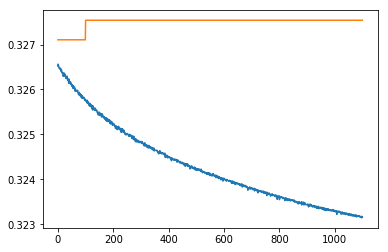

In [64]:
plt.plot(np.concatenate((loss3,loss4)))
plt.plot(np.concatenate((loss_val*np.ones(100),loss_val2*np.ones(1000))))

In [ ]:
A similar plot for the accuracy values

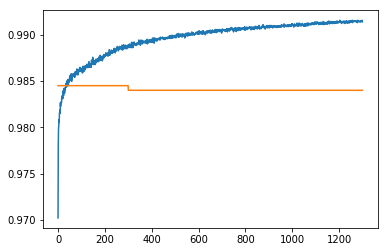

In [67]:
plt.plot(np.concatenate((acc1, acc2, acc3, acc4)))
plt.plot(np.concatenate((acc_val*np.ones(300),acc_val2*np.ones(1000))))

## Exercise

What is happening?

My plots are ugly and perhaps even misleading! 

Make better plots on which we see the evolution of the loss/accuracy on both the training and validation sets as a function of the number of epochs.

## 5. Viewing model prediction (qualitative analysis)

The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

With our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques after the 2 weeks break...)


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

   1. A few correct labels at random
   2. A few incorrect labels at random
   3. The most correct labels of each class (ie those with highest probability that are correct)
   4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
   5. The most uncertain labels (ie those with probability closest to 0.5).

In general, these are particularly useful for debugging problems in the model. Since our model is very simple, there may not be too much to learn at this stage...

In [68]:
# Number of images to view for each visualization task
n_view = 8

Selecting correct predictions.

In [69]:
correct = np.where(preds==lbs_val)[0]

In [70]:
from numpy.random import random, permutation
idx = permutation(correct)[:n_view]

In [71]:
idx

array([1378, 1525, 1971,  120,   39,  251, 1476, 1317])

In [72]:
dataset_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx],batch_size = n_view,shuffle=True)

In [73]:
for data in dataset_correct:
    inputs_cor,labels_cor = data

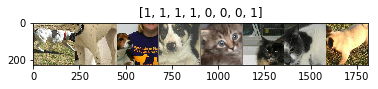

In [75]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_cor)

imshow(out, title=[x for x in labels_cor])

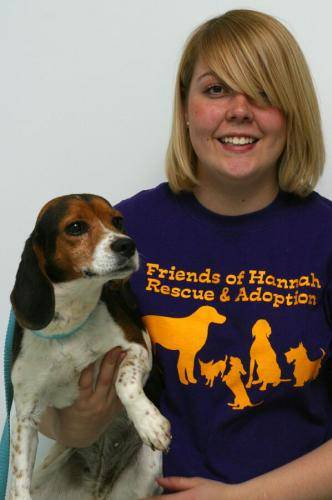

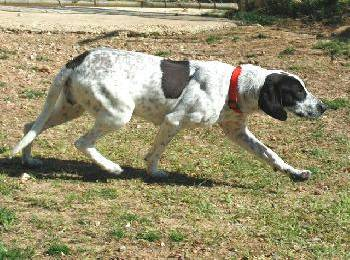

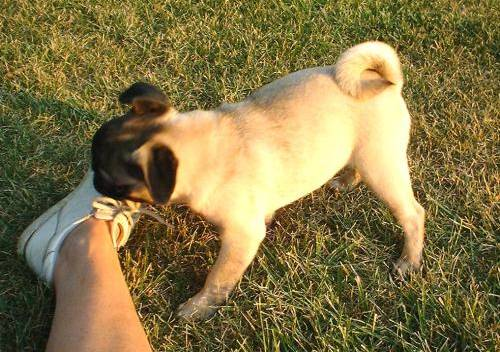

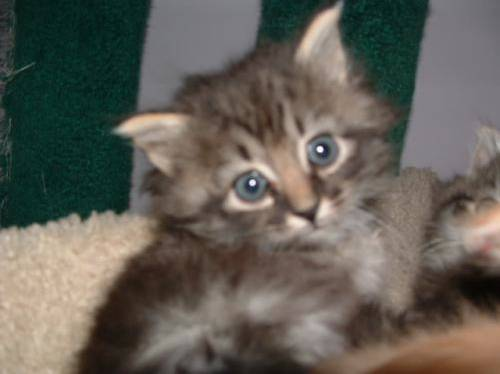

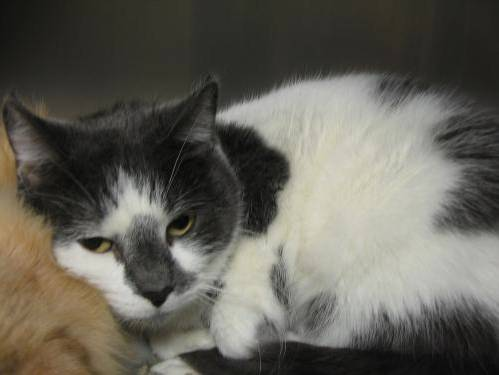

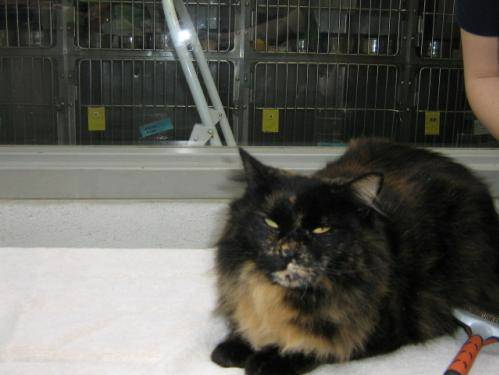

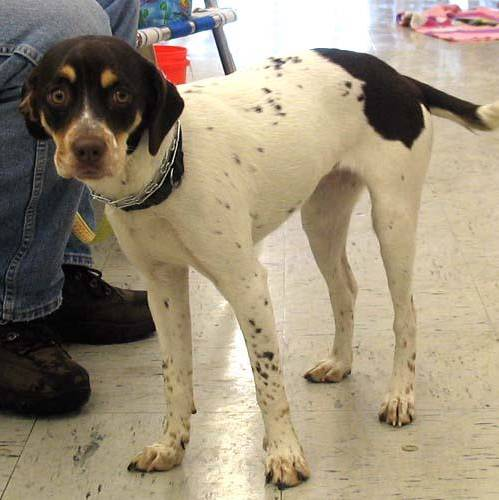

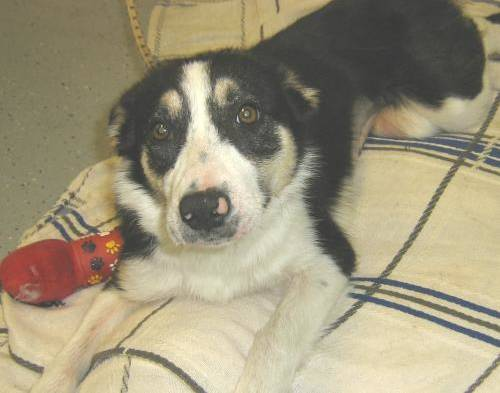

In [76]:
from IPython.display import Image
for x in idx:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

Selecting incorrect predictions.

1


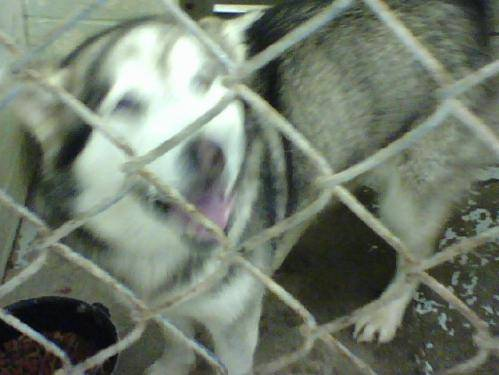

0


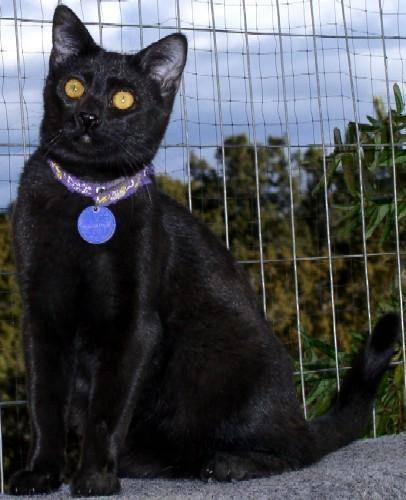

0


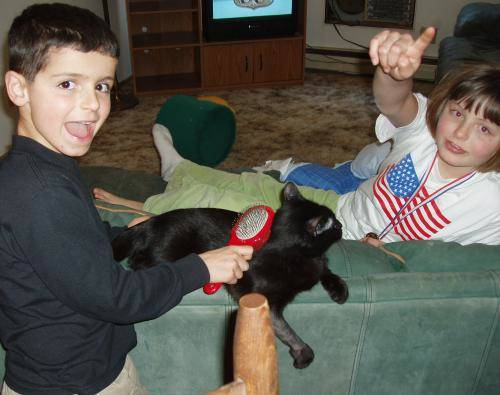

1


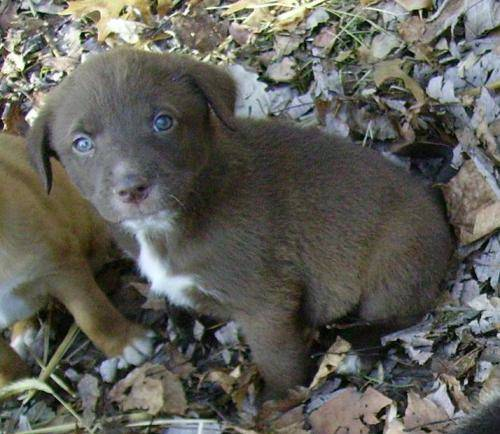

1


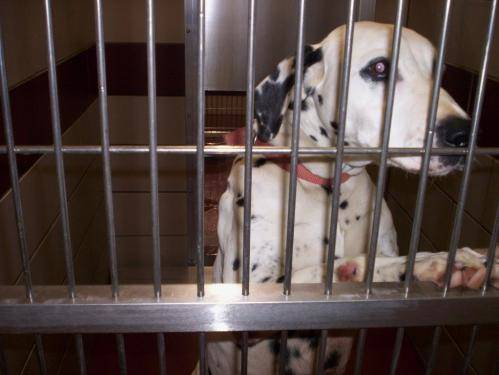

0


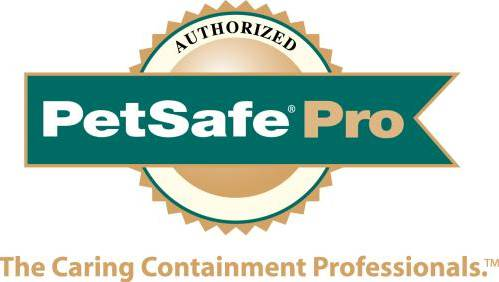

1


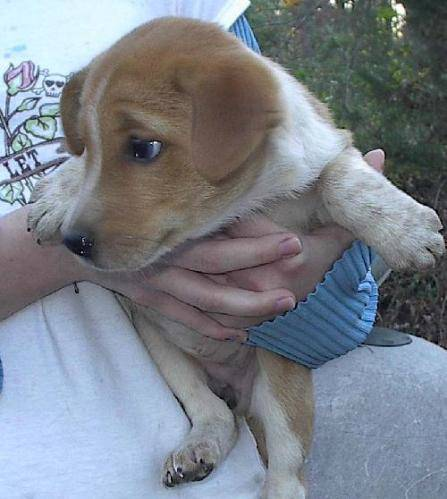

1


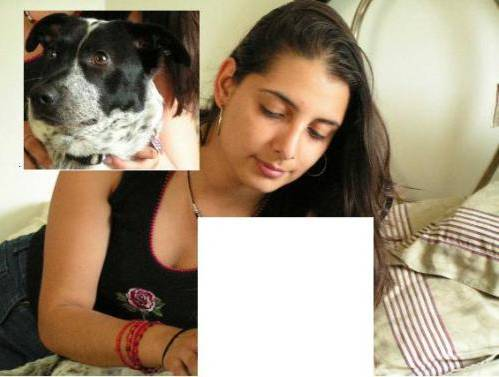

In [77]:
incorrect = np.where(preds!=lbs_val)[0]
for x in permutation(incorrect)[:n_view]:
    print(dsets['valid'].imgs[x][1])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

In [78]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==lbs_val))[0]
most_correct_cats = np.argsort(conf[correct_cats,1])[:n_view]

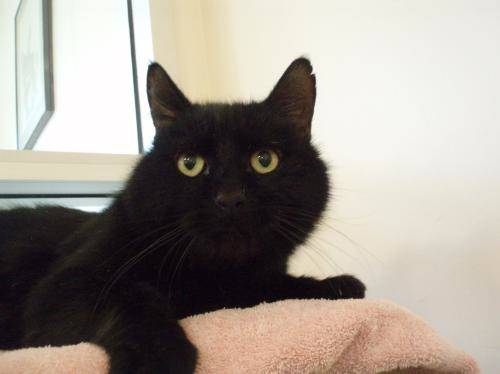

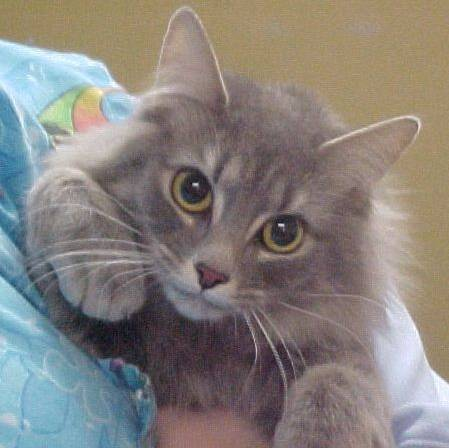

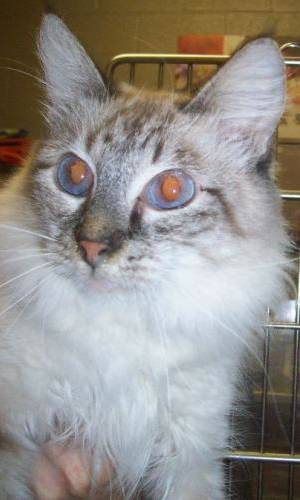

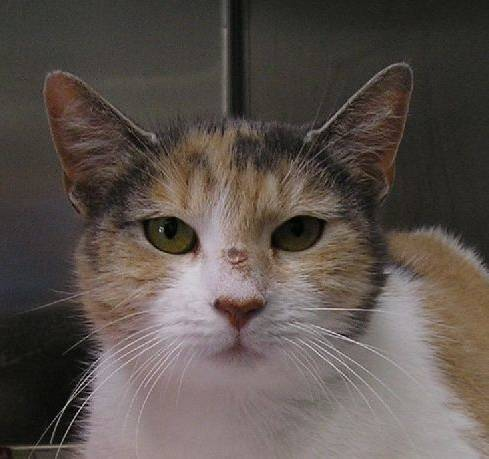

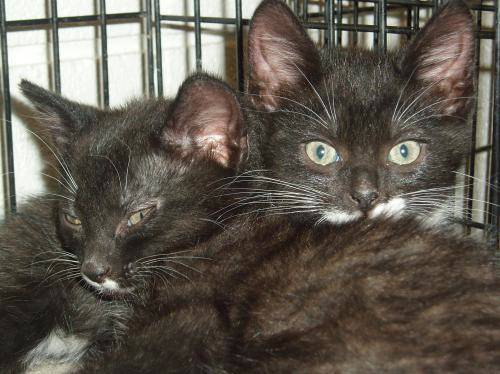

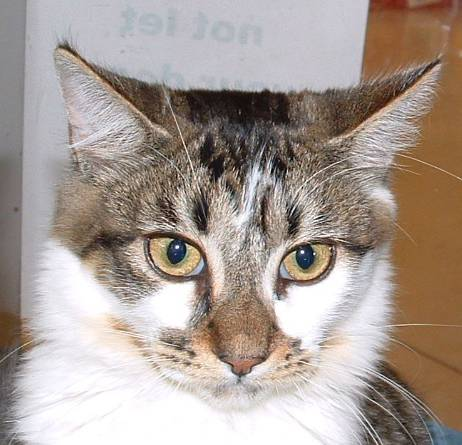

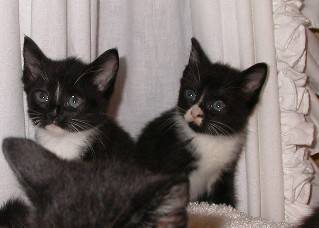

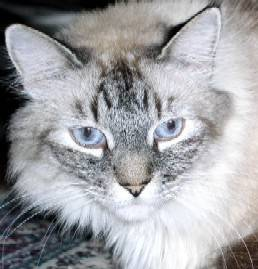

In [79]:
for x in most_correct_cats:
    display(Image(filename=dsets['valid'].imgs[correct_cats[x]][0], retina=True))

In [80]:
#3. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((preds==1) & (preds==lbs_val))[0]
most_correct_dogs = np.argsort(conf[correct_dogs,0])[:n_view]

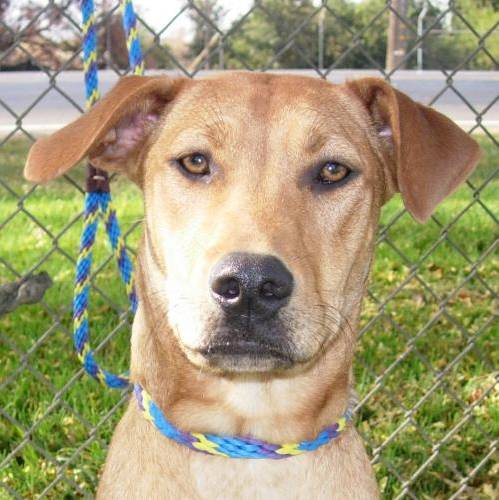

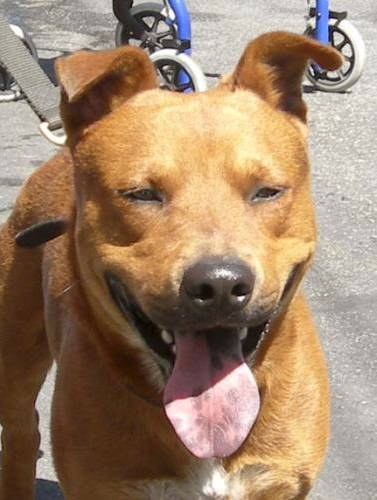

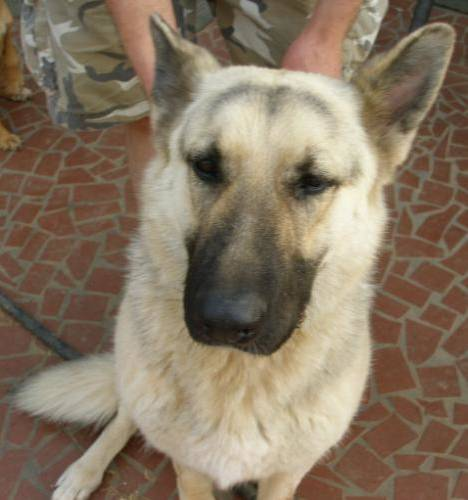

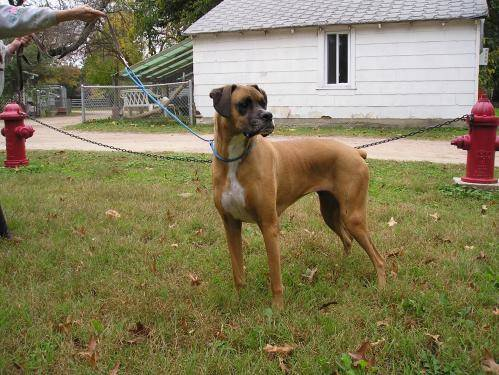

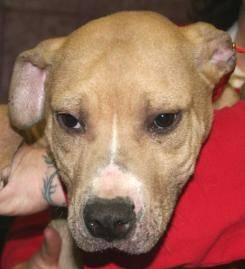

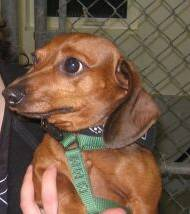

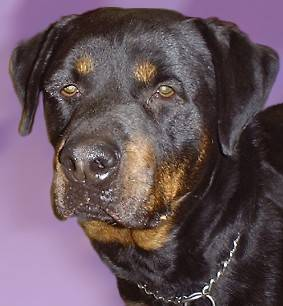

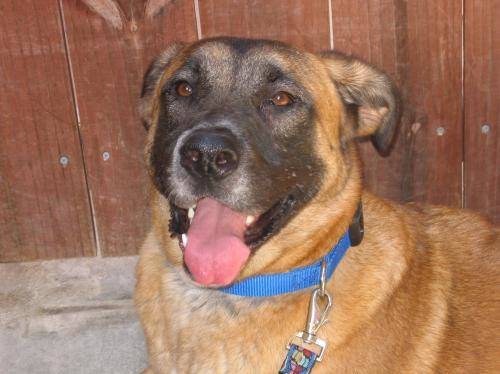

In [81]:
for x in most_correct_dogs:
    display(Image(filename=dsets['valid'].imgs[correct_dogs[x]][0], retina=True))

## Exercise

As seen in the first lecture, the last layer of Vgg16 is simply a dense layer that outputs 1000 elements. Therefore, it seems somewhat unreasonable to stack a dense layer meant to find cats and dogs on top of one that's meant to find imagenet categories, in that we're limiting the information available to us by first coercing the neural network to classify to imagenet before cats and dogs...

Instead, do finetuning, i.e remove that last layer and add on a new layer for cats and dogs. 

Compare to what we did in the first lecture.